In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
 
print("TensorFLow Version : ",tf.__version__)
print("Is Using GPU ?", tf.test.is_gpu_available())

TensorFLow Version :  2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is Using GPU ? False


In [2]:
def get_three_classes(x,y):#the total number of training examples is around 60,000 and test examples are around 10,000 so we are using the subset so that training becomes faster 
    # we are indulging only in the first 3 classes
    indices_0,_ = np.where(y==0.)
    indices_1,_ = np.where(y==1.)
    indices_2,_ = np.where(y==2.)
    
    indices = np.concatenate([indices_0,indices_1,indices_2],axis =0)# concatenating along the first axis , in a particular  sequence (hence we need to shuffle them later)
    #selecting the examples  corresponding to the given indices 
    x =  x[indices]
    y =  y[indices]
    
    count = x.shape[0] #This gives the total numbers of the examples selected
   
    #shuffling the indices, 
    indices = np.random.choice(range(count), count , replace=False)#replace = False ensures that we only have unique values
    
    x =  x[indices]
    y =  y[indices]
    
    y = tf.keras.utils.to_categorical(y) #converting the labels into one hot encoded vectors
    
    return x,y
    

In [3]:
#Loading the data set
(x_train,y_train) ,(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
#getting the required data and lables according to the 3 chosen classes
x_train,y_train = get_three_classes(x_train ,y_train)
x_test , y_test = get_three_classes(x_test,y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape,y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


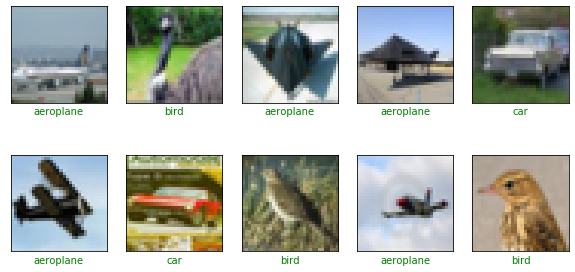

In [5]:
#Visualizing the examples 
classes_name = ['aeroplane','car','bird']

def show_random_examples(x,y,p):#p - prediction (if any)
    indices = np.random.choice(range(x.shape[0]),10,replace= False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10,5))
    
    for i in range(10):
        plt.subplot(2,5,1+i)# 2-rows , 5-columns 
        plt.imshow(x[i])
        #eliminating the ticks along x-axis and y-axis to have clear image
        plt.xticks([])
        plt.yticks([])
        col="green" if np.argmax(y[i]) == np.argmax(p[i]) else "red"
        plt.xlabel(classes_name[np.argmax(p[i])],color=col)
    plt.show()
    
show_random_examples(x_train,y_train,y_train)    
        



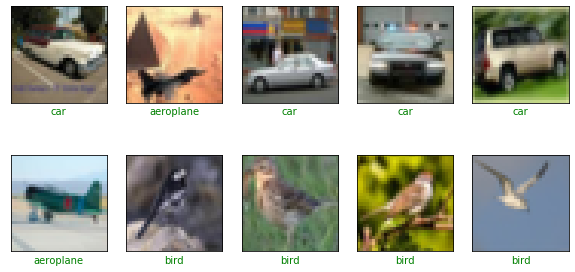

In [6]:
show_random_examples(x_test,y_test,y_test) 

In [7]:
#Creating the model :

from tensorflow.keras.layers import Conv2D , MaxPooling2D ,BatchNormalization ,Dropout ,Flatten, Input,Dense

In [8]:
def create_model():
    def add_conv_block(model , num_filters):
        model.add(Conv2D(num_filters,3, activation='relu',padding='same',))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters,3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
        
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
    
    model =  add_conv_block(model,32)
    model =  add_conv_block(model,64)
    model =  add_conv_block(model,128)
    
    model.add(Flatten())
    model.add(Dense(3,activation ='softmax'))
    
    model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']          
    )
    
    return model
    

In [9]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

In [10]:
#Training the model

history = model.fit(
    x_train/255. , y_train,
    validation_data =(x_test/255. , y_test),
    epochs =10,
    batch_size=128,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor ='val_accuracy', patience = 3),#if the validation accuracy does not increase for 3 iterations then we will stop the traing
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',save_best_only=True,save_weights_only=False , monitor='val_accuracy'
                                          )
    ]
)

Epoch 1/10
118/118 [==============================] - 59s 498ms/step - loss: 0.8842 - accuracy: 0.6812 - val_loss: 2.0653 - val_accuracy: 0.3333
Epoch 2/10
118/118 [==============================] - 58s 491ms/step - loss: 0.5577 - accuracy: 0.7761 - val_loss: 2.2732 - val_accuracy: 0.5417
Epoch 3/10
118/118 [==============================] - 54s 454ms/step - loss: 0.4834 - accuracy: 0.8087 - val_loss: 1.7538 - val_accuracy: 0.5623
Epoch 4/10
118/118 [==============================] - 56s 472ms/step - loss: 0.4482 - accuracy: 0.8206 - val_loss: 1.0207 - val_accuracy: 0.6280
Epoch 5/10
118/118 [==============================] - 57s 482ms/step - loss: 0.4130 - accuracy: 0.8376 - val_loss: 0.3935 - val_accuracy: 0.8500
Epoch 6/10
118/118 [==============================] - 53s 452ms/step - loss: 0.3830 - accuracy: 0.8501 - val_loss: 0.3638 - val_accuracy: 0.8637
Epoch 7/10
118/118 [==============================] - 53s 451ms/step - loss: 0.3558 - accuracy: 0.8637 - val_loss: 0.3764 - val_ac

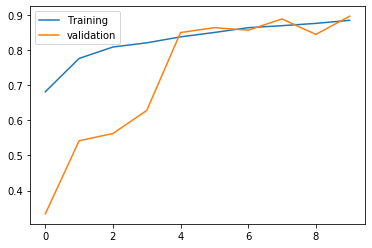

In [11]:
ac = history.history['accuracy']
val_ac = history.history['val_accuracy']

plt.plot(range(len(ac)), ac , label = 'Training')
plt.plot(range(len(ac)), val_ac , label = 'validation')
plt.legend()
plt.show()

In [15]:
model = tf.keras.models.load_model('models/model_0.896.h5')
preds = model.predict(x_test/255.)


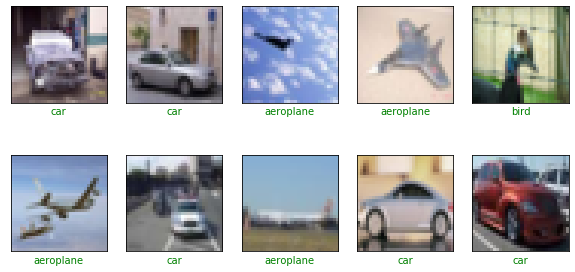

In [16]:
show_random_examples(x_test,y_test,preds)